# Project FILIÈRE RECHERCHE

Under the supervision of :

Elisabeth Lahalle

Students :

- Ricardo Chiquetto do Lago
- Maxsuel Fernandes de Almeida
- Samara Ndiaye
- Ana Cecilia Reghini
- Lucas Tramonte

# Libraries

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats import norm
from scipy.ndimage import binary_dilation, binary_closing

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM ,Dropout , Dense 

2024-09-13 09:17:50.862272: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 09:17:51.012948: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 09:17:51.159454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 09:17:51.290183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 09:17:51.328047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 09:17:51.559362: I tensorflow/core/platform/cpu_feature_gu

# Data

In [3]:
data_gamma_irradiation = pd.read_csv("Assets/Data/2015_months_DebitDoseA.csv")
data_hygometry = pd.read_csv("Assets/Data/2015_months_HYGR.csv")
data_patm = pd.read_csv("Assets/Data//2015_months_PATM.csv")
data_temp = pd.read_csv("Assets//Data//2015_months_TEMP.csv")

In [4]:
data = data_gamma_irradiation.copy()
data

,24/02/2015 11:20,30/04/2015 13:10,22/06/2015 07:31,20/10/2015 09:18
0,92.8536,96.38690,96.98370,104.8191
1,91.8084,95.68260,96.33440,103.6979
2,93.3221,97.17039,96.67419,104.6446
3,91.7464,97.41650,97.40680,104.3136
4,93.4146,97.39280,97.60400,104.5342
...,...,...,...,...
40314,103.1037,97.12400,101.08090,97.3781
40315,102.4074,98.34760,100.19280,98.0843
40316,103.0529,98.91140,101.56070,99.6903
40317,102.9746,98.82339,101.22470,100.9240


# Data Visualization

In [5]:
data

,24/02/2015 11:20,30/04/2015 13:10,22/06/2015 07:31,20/10/2015 09:18
0,92.8536,96.38690,96.98370,104.8191
1,91.8084,95.68260,96.33440,103.6979
2,93.3221,97.17039,96.67419,104.6446
3,91.7464,97.41650,97.40680,104.3136
4,93.4146,97.39280,97.60400,104.5342
...,...,...,...,...
40314,103.1037,97.12400,101.08090,97.3781
40315,102.4074,98.34760,100.19280,98.0843
40316,103.0529,98.91140,101.56070,99.6903
40317,102.9746,98.82339,101.22470,100.9240


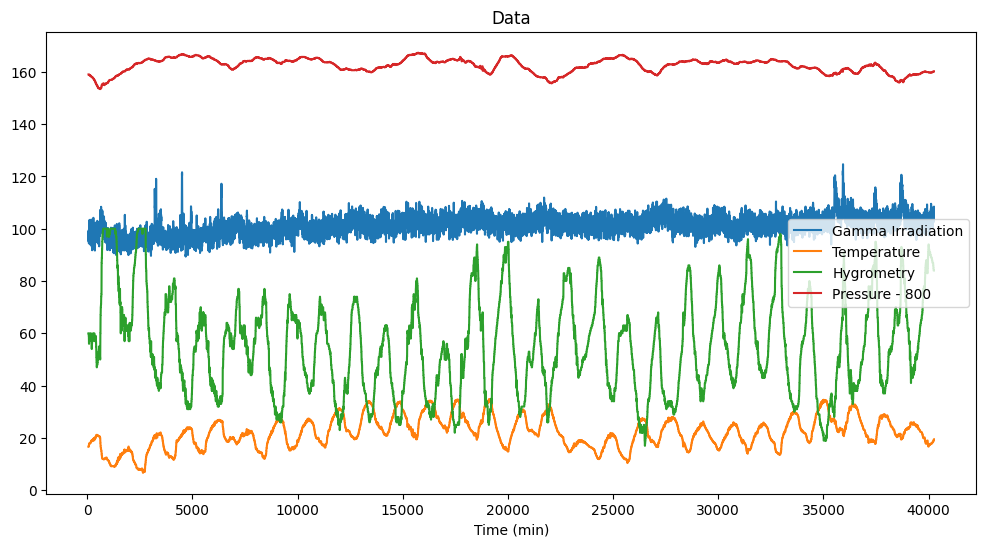

In [6]:
# Define the month (1: February, 2: April, 3: June, 4: October)
month = 3  # selected month: June

# Extract data for the selected month
sigg = data.iloc[:, month-1]  # Gamma irradiation data
sigt = data_temp.iloc[:, month-1]               # Temperature data
sigh = data_hygometry.iloc[:, month-1]          # Hygrometry data
sigp = data_patm.iloc[:, month-1]               # Atmospheric pressure data

# Remove the first and last hour of data
N = len(sigg)  # number of data points
fe = 1/60      # sampling frequency
t = list(range(N))  # time vector

Nh = 60  # 1 hour
t_trimmed = t[Nh:N-Nh]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_trimmed, sigg[Nh:N-Nh], label='Gamma Irradiation')
plt.plot(t_trimmed, sigt[Nh:N-Nh], label='Temperature')
plt.plot(t_trimmed, sigh[Nh:N-Nh], label='Hygrometry')
plt.plot(t_trimmed, sigp[Nh:N-Nh] - 800, label='Pressure - 800')

plt.xlabel('Time (min)')
plt.title('Data')
plt.legend()
plt.show()


### IQR for outlier detection 

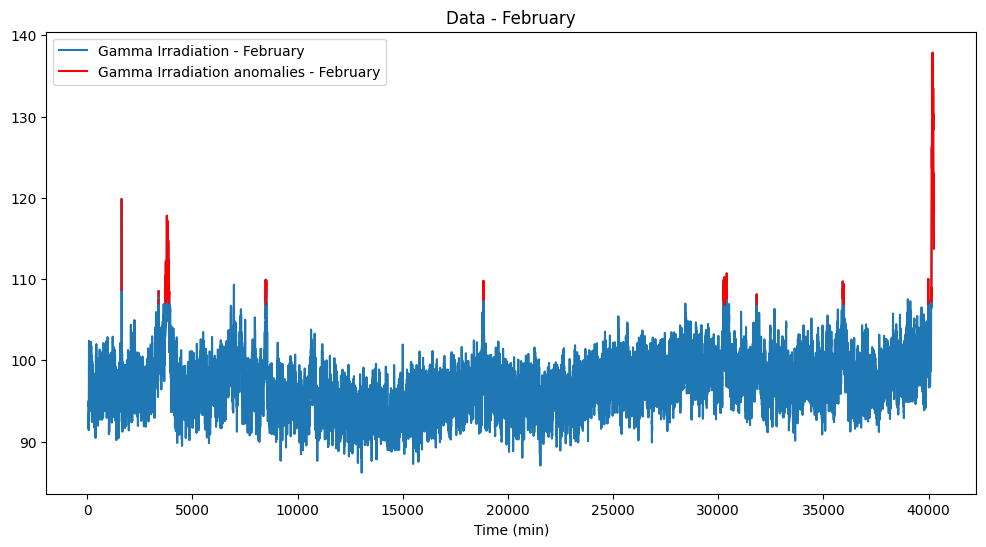

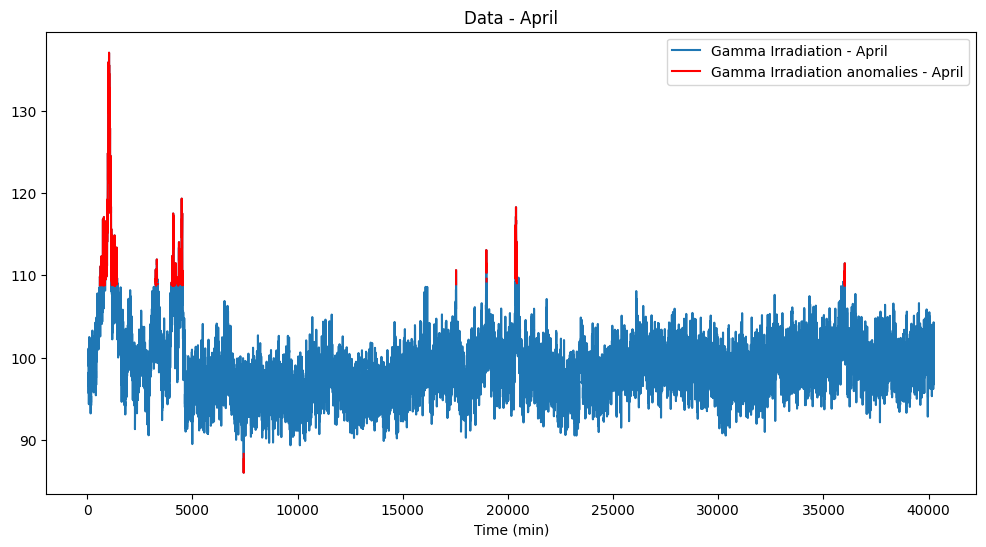

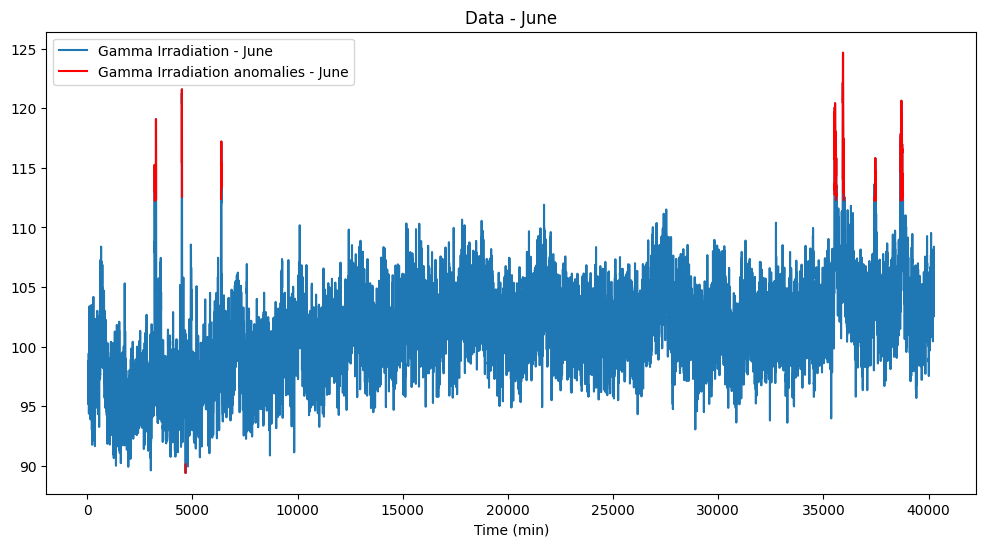

In [7]:
def IQR(X_train, month_col, month_name):
    """
    Function to process the data for a specific month, detect anomalies, and plot the results.
    
    Parameters:
    - X_train: DataFrame containing training data for all columns
    - month_col: index or name of the column representing the specific month to be processed
    - month_name: name of the month (for plot title)
    """
    # Extract data for the selected month
    sigg = X_train.iloc[:, month_col]

    # Remove the first and last hour of data
    N = len(sigg)  # number of data points
    Nh = 60  # 1 hour (60 minutes)
    t = list(range(N))  # time vector
    t_trimmed = t[Nh:N-Nh]  # trimming first and last hour

    ## Anomaly: IQR
    Q1 = sigg.quantile(0.25)
    Q3 = sigg.quantile(0.75)
    IQR = Q3 - Q1

    threshold_lower = Q1 - 2 * IQR
    threshold_upper = Q3 + 2 * IQR

    # Detect anomalies
    anomalies = X_train[(X_train < threshold_lower) | (X_train > threshold_upper)]
    sigg_anomaly = anomalies.iloc[:, month_col]

    # Remove the first and last hour of anomaly data
    N_a = len(sigg_anomaly)  # number of data points
    t_a = list(range(N_a))  # time vector for anomalies
    t_trimmed_a = t_a[Nh:N_a-Nh]

    plt.figure(figsize=(12, 6))
    plt.plot(t_trimmed, sigg[Nh:N-Nh], label=f'Gamma Irradiation - {month_name}')
    plt.plot(t_trimmed_a, sigg_anomaly[Nh:N_a-Nh], label=f'Gamma Irradiation anomalies - {month_name}', color='r')

    plt.xlabel('Time (min)')
    plt.title(f'Data - {month_name}')
    plt.legend()
    plt.show()

# Split the data into training and testing sets
X_train = data.iloc[:, 0:3]
# Remove rows where any value in the row exceeds 200
X_train = X_train.loc[(X_train <= 160).all(axis=1)]
X_test = data.iloc[:, -1]

IQR(X_train, 0, "February") 
IQR(X_train, 1, "April")    
IQR(X_train, 2, "June")     


### Removing the huge outlier in February

In [8]:
# Defining the structuring element for binary dilation
structure = np.ones(5)  # Window size 5

# Function to remove outliers, replacing values above the threshold with the mean
def remove_outliers(s, threshold=800):
    s = s.copy()
    idx = s > threshold
    expanded_series = binary_dilation(idx, structure=structure)
    mu = s.mean()
    s[expanded_series] = mu
    return s

# Apply outlier removal to the first month of gamma irradiation data
filtered_data = data_gamma_irradiation.copy()
filtered_data.iloc[:, 0] = remove_outliers(data_gamma_irradiation.iloc[:, 0])

### SDT method to detect collectif motifs

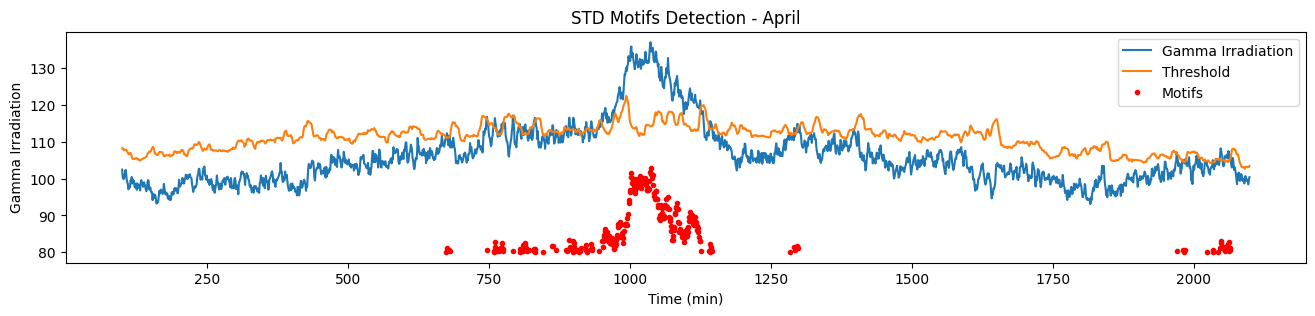

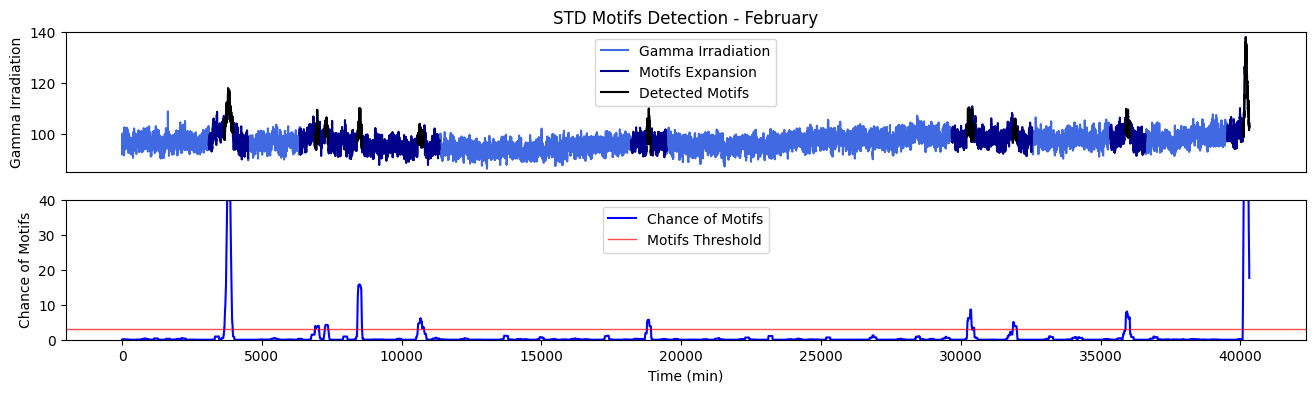

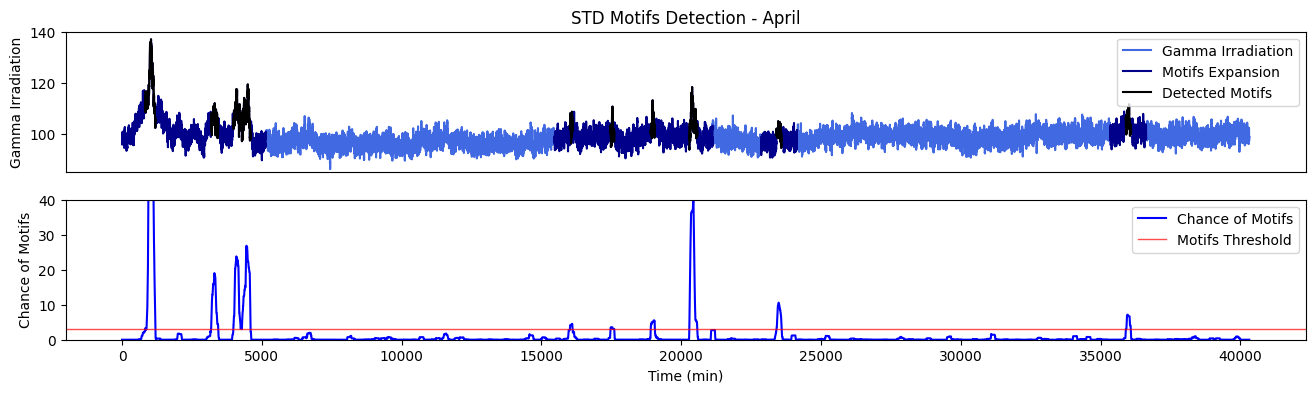

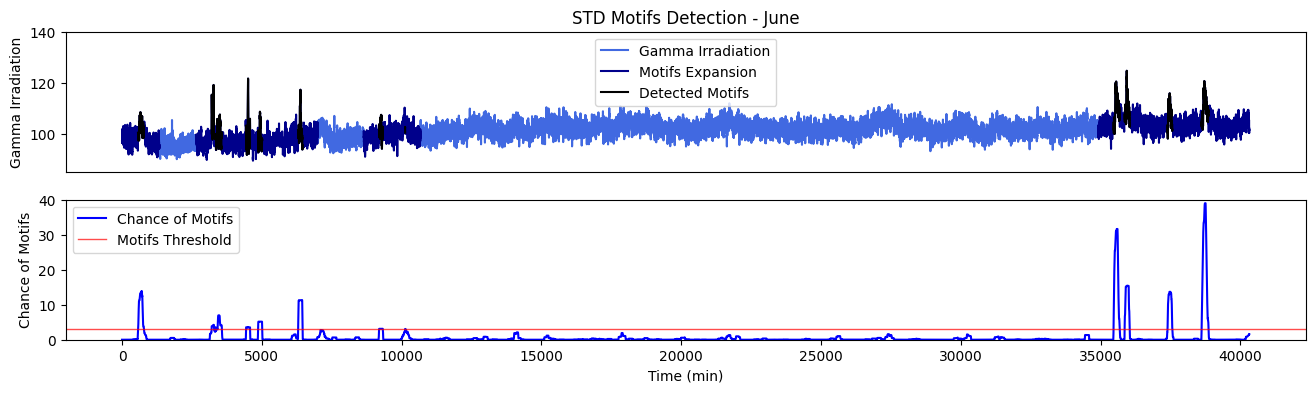

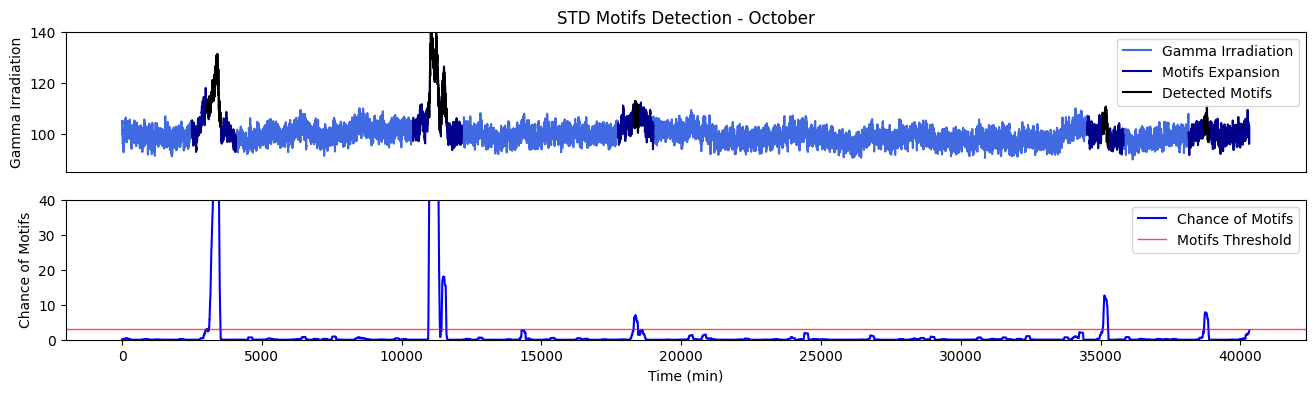

In [9]:
# Function to compute the moving mean
def compute_moving_mean(signal, window_size):
    return signal.rolling(window=window_size, min_periods=1, center=True).mean()

# Function to compute the moving standard deviation
def compute_moving_std(signal, window_size):
    return signal.rolling(window=window_size, min_periods=1, center=True).std()

# Select the signal and time
signal = filtered_data.iloc[:, :]  
time = t  

# Window parameters
lw = 20  # Window length for moving standard deviation
n = 70   # Multiplier for the moving mean window

# Step 1: Compute the moving mean with window size n*lw
moving_mean = compute_moving_mean(signal, window_size=n*lw)

# Step 2: Compute the moving standard deviation with window size lw
moving_std = compute_moving_std(signal, window_size=lw)

# Step 3: Compute the threshold as moving_mean + 3 * moving_std
threshold = moving_mean + 3 * moving_std

# Step 4: Identify points in the signal that exceed the threshold
dif = signal - threshold
dif[dif < 0] = 0

# Step 5: Motif detection
coef = 10  # Multiplicative factor for visualization
dif_mean = compute_moving_mean(dif, 150) * coef  # Moving mean of dif
th = 0.3 * coef  # Threshold for motif detection
detection = dif_mean > th  # Motif detection

# Step 6: Dilation of the detected motifs
dilatation_window = np.ones(shape=(1100, 1))  
expanded_window = np.ones(shape=(1000, 1))  
expanded_detection = binary_dilation(detection, structure=dilatation_window)
closed_detection = binary_closing(expanded_detection, structure=expanded_window, border_value=True)

# Step 7: Motif extraction
motifs = signal[expanded_detection]
plotable_dif = dif[dif > 0]

# Plot the data (Zoom In for April) 
month = 2  # selected month: April
plt.figure(figsize=(16, 3))
plt.plot(time[100:2100], signal.iloc[100:2100, month-1], label='Gamma Irradiation')
plt.plot(time[100:2100], threshold.iloc[100:2100, month-1], label='Threshold')
plt.plot(80 + plotable_dif.iloc[100:2100, month-1], 'o', label='Motifs', color='red', markersize=3)
plt.xlabel('Time (min)')
plt.ylabel('Gamma Irradiation')
plt.title(f'STD Motifs Detection - April')
plt.legend()

# Zoom out plot (analysis for different months)
months = ['February', 'April', 'June', 'October']  # Define the months
for i in range(4):
    plt.figure(figsize=(16, 4))

    plt.subplot(2, 1, 1)
    plt.title(f'STD Motifs Detection - {months[i]}')
    plt.plot(time, signal.mask(closed_detection).iloc[:, i], label='Gamma Irradiation', color="royalblue")
    plt.plot(time, signal.mask(~closed_detection).iloc[:, i], label='Motifs Expansion', color="darkblue")
    plt.plot(time, signal[detection].iloc[:, i], label='Detected Motifs', color="black")
    plt.ylim(85, 140)
    plt.xticks([])
    plt.ylabel('Gamma Irradiation')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time, dif_mean.iloc[:, i], label='Chance of Motifs', color="blue")
    plt.axhline(y=th, color='red', label='Motifs Threshold', linestyle='-', linewidth=1, alpha=0.7)
    plt.ylim(0, 40)
    plt.xlabel('Time (min)')
    plt.ylabel('Chance of Motifs')
    plt.legend()


plt.show()

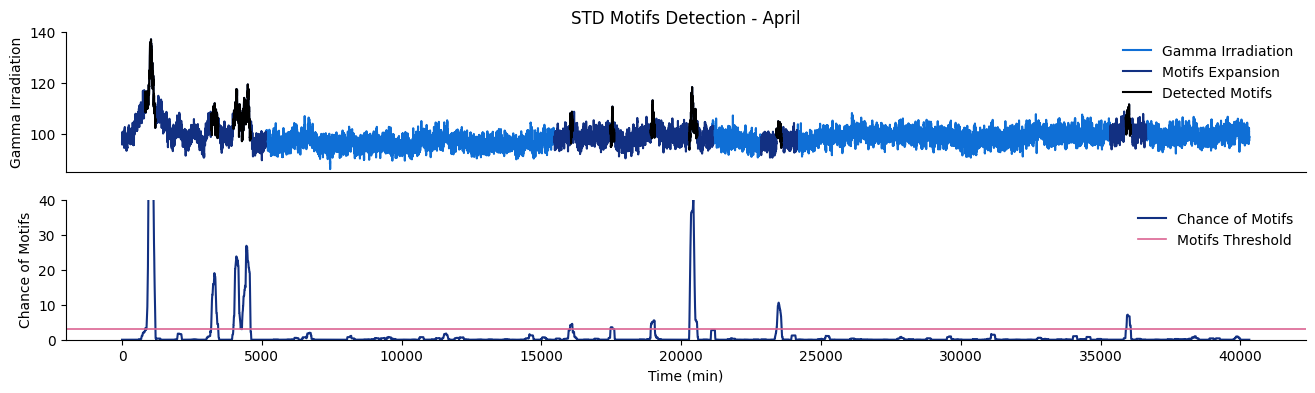

In [21]:
# For banner image
plt.figure(figsize=(16, 4))

ax = plt.subplot(2, 1, 1)
plt.title(f'STD Motifs Detection - April')
plt.plot(time, signal.mask(closed_detection).iloc[:, 1], label='Gamma Irradiation', color="#0F6FD6")
plt.plot(time, signal.mask(~closed_detection).iloc[:, 1], label='Motifs Expansion', color="#123082")
plt.plot(time, signal[detection].iloc[:, 1], label='Detected Motifs', color="black")
plt.ylim(85, 140)
plt.xticks([])
plt.ylabel('Gamma Irradiation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False)

ax = plt.subplot(2, 1, 2)
plt.plot(time, dif_mean.iloc[:, 1], label='Chance of Motifs', color="#123082")
plt.axhline(y=th, color='#DB6592', label='Motifs Threshold', linestyle='-', linewidth=1.2, alpha=1)
plt.ylim(0, 40)
plt.xlabel('Time (min)')
plt.ylabel('Chance of Motifs')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [10]:
def false_sequence_extractor(signal, boolean_mask):
    # Find the indices where the value changes
    change_points = np.asarray(np.diff(boolean_mask.astype(int)) != 0).nonzero()[0] + 1
    
    # Add start and end points for completeness
    change_points = np.concatenate(([0], change_points, [len(boolean_mask)]))
    
    # Extract sequences of False values
    false_sequences = []
    for i in range(len(change_points) - 1):
        start, end = change_points[i], change_points[i + 1]
        if not boolean_mask[start]:
            false_sequences.append(signal[start:end])
    
    return false_sequences

normal_signals_df = pd.DataFrame(index=range(24237)) # 24237 is the length of the longest sequence
num = 0

# Dictionary to hold the total count of data points for each month
month_data_count = {1: 0, 2: 0, 3: 0, 4: 0}
months = ['February', 'April', 'June', 'October']

# Extract sequences of normal (False) values and calculate total lengths for each month
for i in range(4):
    normal_sequences = false_sequence_extractor(signal.iloc[:, i], closed_detection[:, i])
    for j, sequence in enumerate(normal_sequences):
        sequence.reset_index(drop=True, inplace=True)
        normal_signals_df[f'Normal {num}'] = sequence
        month_data_count[i + 1] += len(sequence)  # Add the length of the sequence to the corresponding month
        num += 1
        
for i in range(4):
    print(f'Total data points for {months[i]}: {month_data_count[i + 1]}')
    
#save the normal sequences
normal_signals_df.to_json('Assets/Data/normal_sequences_df.json')

Total data points for February: 27752
Total data points for April: 26951
Total data points for June: 27191
Total data points for October: 32285


In [11]:
df = pd.read_json('Assets/Data/normal_sequences_df.json')
df

,Normal 0,Normal 1,Normal 2,Normal 3,Normal 4,Normal 5,Normal 6,Normal 7,Normal 8,Normal 9,Normal 10,Normal 11,Normal 12,Normal 13,Normal 14,Normal 15,Normal 16,Normal 17
0,92.8536,92.18880,95.8828,94.8914,99.3786,96.7514,96.9369,102.7642,101.2285,99.16351,94.1505,100.0079,100.2875,104.8191,99.4430,97.9886,104.4413,99.04060
1,91.8084,92.15730,95.8420,94.9091,98.5778,95.6769,98.1709,103.4576,100.1578,99.51540,93.8183,98.9602,99.9778,103.6979,99.8385,98.0168,106.7259,98.60550
2,93.3221,91.04920,96.6909,93.1362,100.5174,95.2383,97.2632,103.1363,99.5451,100.86030,93.8409,96.4416,99.7778,104.6446,97.2070,97.0139,105.6565,98.63969
3,91.7464,91.41209,96.1315,91.9638,100.5789,95.6203,98.8041,104.1119,99.3246,101.34160,94.3847,96.3220,101.0415,104.3136,96.1077,96.5949,105.4823,98.28619
4,93.4146,90.21999,95.6273,92.8258,100.1589,94.4122,99.2989,102.8876,98.3568,100.84000,91.8086,96.3410,102.1783,104.5342,95.7765,98.6133,103.7953,98.66600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.8365,NaN,NaN,NaN,NaN,NaN
24233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.7869,NaN,NaN,NaN,NaN,NaN
24234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.3682,NaN,NaN,NaN,NaN,NaN
24235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.8543,NaN,NaN,NaN,NaN,NaN


In [12]:
(df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)

Normal 10    94.570285
Normal 11    93.241738
Normal 7     92.849775
Normal 1     92.383546
Normal 17    90.370095
Normal 13    89.685192
Normal 4     88.488674
Normal 5     87.898667
Normal 0     87.189009
Normal 9     84.787721
Normal 15    76.911334
Normal 14    73.849899
Normal 2     71.659034
Normal 3     57.878450
Normal 6     57.408095
Normal 8     53.756653
Normal 16    35.978050
Normal 12     0.000000
dtype: float64

# LSTMs

In [13]:
def create_model(n_0 ,n_1 ,input=1):

    return Sequential(
        [
            LSTM(n_0, input_shape=(None, input), return_sequences=True),
            Dropout(0.2),
            LSTM(n_1),
            Dropout(0.2),
            Dense(1),
        ]
    ) 

def train_model (model ,X_train,Y_train,n_epoch):
    
    model.compile(loss='mse',optimizer='Adam')

    model.fit(X_train , Y_train, epochs=n_epoch , validation_split=0.1 )

    return model 


# ------------ PREPARE THE DATA FOR TRAINING AND TEST ----------------------------------

df_train = df.copy(deep= True)
X = df_train['Normal 0'].to_numpy() # contains 3105 samples 

df_test = data.copy(deep= True)
X_test=df_test['20/10/2015 09:18'].to_numpy()  #contains all data for the last monthn

#-------------- SCALE THE DATA BEETWEEN 0 AND 1 FOR TRAINING -----------------------------------------

data_concatenate = np.concatenate([X,X_test],axis=0)
data_reshaped = data_concatenate.reshape(-1, 1)

scaler = MinMaxScaler((0,1))
scaled_data = scaler.fit_transform(data_reshaped)

X , X_test = scaled_data[:3105],scaled_data[3105:] 

def create_sequence(seq ,ls ):
    X=[]
    y=[]
    for i in range (len(seq) -ls):
        X.append(seq[i:i+ls])
        y.append(seq[i+ls])

    return np.array(X) ,np.array(y)

x,y =create_sequence(X , ls= 100)
x_train ,x_val ,y_train ,y_val = train_test_split( x ,y ,test_size= 0.2 )

x_test,y_test=create_sequence(X_test , ls= 100)

In [14]:
#-------------------  TRAIN AND SAVE THE MODEL  ----------------------------------------

model=create_model(80 ,80 )
model.summary()

model = train_model(model,x_train,y_train,50)
model.save('Assets/LSTM.h5')

/home/maxsuelfa/tf-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 80)       │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80)             │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,841 (304.07 KB)

 Trainable params: 77,841 (304.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0011 - val_loss: 9.3927e-04
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0010 - val_loss: 8.4175e-04
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0010 - val_loss: 7.7957e-04
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 9.3338e-04 - val_loss: 7.0750e-04
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 8.9553e-04 - val_loss: 7.8936e-04
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 8.2286e-04 - val_loss: 7.1959e-04
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 8.1144e-04 - val_loss: 5.8800e-04
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 7.3248e-04 - val_loss: 5.5084e-04
Epoch 12/50

In [15]:
model=tf.keras.models.load_model('Assets/LSTM.h5' ,compile=False)
model.compile(optimizer='adam', loss='mse')

### Threshold determination   : The first method consist of making the assumption that the errors are gaussian and calculate threshold 

In [43]:
class normal_threshold:

    def __init__(self , X_val ,Y_val ,model ,thres =0.9) :

        self.model=model
        self.errors=model.predict(X_val)-Y_val
        self.mu =np.mean(self.errors)
        self.sigma =np.std(self.errors)
        self.eps = norm.pdf(norm.ppf(thres, loc=self.mu, scale=self.sigma) ,  self.mu  ,  self.sigma)
    

    def classify( self , X_test ,Y_test ):
        errors=self.model.predict(X_test) - Y_test


        p = np.array([norm.pdf(x, self.mu , self.sigma)[0]  for x in errors])
        prediction =np.array([ p< self.eps ])  

        return prediction , p , self.eps


threshold = normal_threshold(x_val,y_val,model, thres= 0.95)
prediction ,p, eps  =threshold.classify(x_test,y_test)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step
[[       nan]
 [       nan]
 [       nan]
 ...
 [0.16299282]
 [0.18876927]
 [0.20874396]]


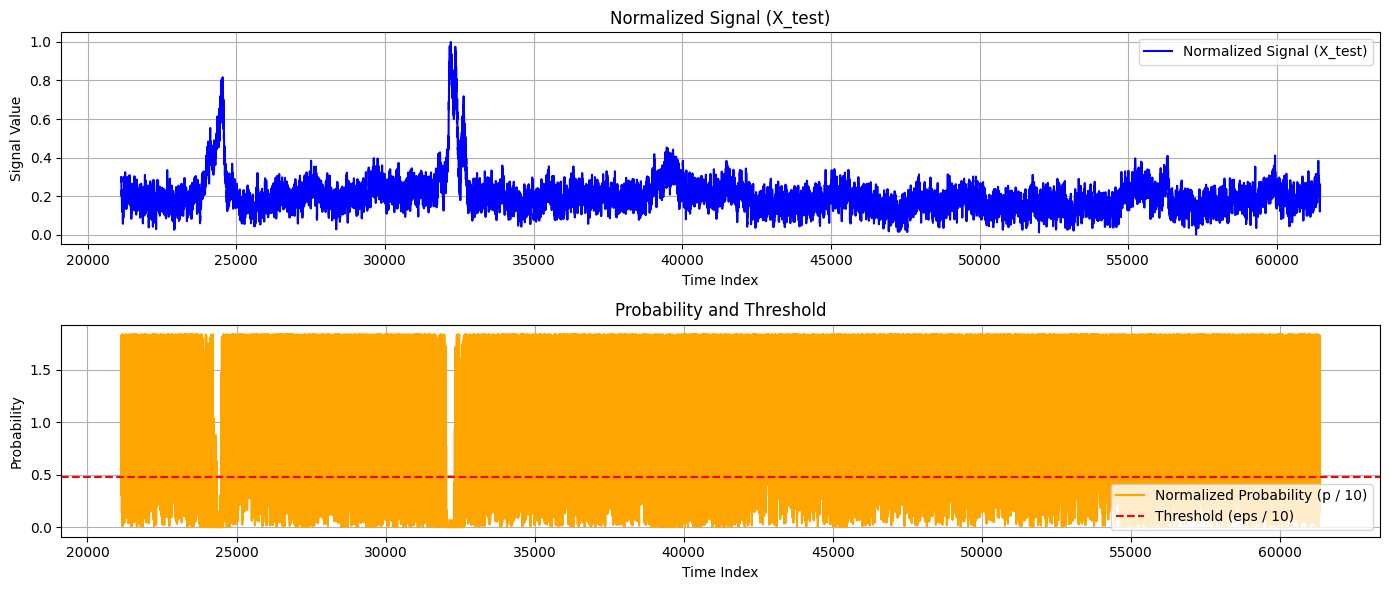

In [17]:
# Plot the X_test signal
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(X_test, label='Normalized Signal (X_test)', color='blue')
plt.xlabel('Time Index')
plt.ylabel('Signal Value')
plt.title('Normalized Signal (X_test)')
plt.legend()
plt.grid(True)

# Plot the probability p and the threshold
plt.subplot(2, 1, 2)
plt.plot(p/10 , label='Normalized Probability (p / 10)', color='orange')
plt.axhline(eps/10 , color='red', linestyle='--', label='Threshold (eps / 10)')
plt.xlabel('Time Index')
plt.ylabel('Probability')
plt.title('Probability and Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- p represents the probability values of the signals obtained from the model. A signal that is very unlikely (low p-value) is considered anomalous.

- The threshold (eps / 10) is used as a reference line on the plot to compare against the normalized probabilities. This threshold represents a critical value above which the probabilities are considered significant or anomalous.

### Second thresholding method  :need to explore more the github 

# Dynamic Thresholding

In [44]:
from more_itertools import consecutive_groups
def dynamic_thresholding(e_h, X_test, y_test, model):
    """
    
    Args:
    
    Return:

    """
    pred = model.predict(X_test)
    error = abs(pred - y_test)
    #print(error)
    e_s = np.array(error)
    e_s = np.exp(e_s) / np.sum(np.exp(e_s))
    # e_s = np.concatenate((e_h, e_s))
    e_s_mean = np.mean(e_s)
    e_s_std = np.std(e_s)
    #print(e_s)
    max_score = -np.inf
    final_epsilon = 0.0
    for z in np.arange(2.0, 10.0, 0.5):
        epsilon = e_s_mean + z * e_s_std
        pruned_es = e_s[e_s < epsilon]
        #print(epsilon)
        #e_a = e_s[e_s > epsilon]
        anom_idx = np.argwhere(e_s >= epsilon)

        if len(anom_idx) > 0:
            print("qa")
            groups = [list(group) for group
                          in consecutive_groups(anom_idx)]
            E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

            delta_mean = e_s_mean - np.mean(pruned_es)
            delta_std = e_s_std - np.std(pruned_es)

            score = ((delta_mean / e_s_mean) + (delta_std / e_s_std)) \
                    / (len(E_seq) ** 2 + len(anom_idx))
            
            if score > max_score:
                final_epsilon = epsilon

    print(final_epsilon)
    return e_s, final_epsilon




In [45]:
e_s, eps = dynamic_thresholding(None, x_test, y_test, model)
print(e_s)

1918/1918 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step
[[       nan]
 [       nan]
 [       nan]
 ...
 [0.19460542]
 [0.21890722]
 [0.2556997 ]]
